# Определение токсичности комментария

## Описание данных
* *text* - текст комментария
* *toxic* - целевой признак

## 1. Функции

In [1]:
!pip install -U seaborn pandas 1>/dev/null

In [2]:
!pip freeze > requirements.txt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# загрузка/сохранение данных
import requests
from urllib.parse import urlencode

# обработка данных
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# подготовка признаков
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# обучение
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer

In [4]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/mary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [6]:
def split(X, y, test_size=0.3):
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42)
  return (X_train, X_test, y_train, y_test)

In [7]:
def grid_search(model, X, y, params, scoring=make_scorer(f1_score), cv=3, verbose=True):
  grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose, n_jobs=-1)
  grid.fit(X, y)
  if verbose:
    print("The best grid: ", grid.best_params_)
  return grid.best_estimator_

In [8]:
def score_stat(model, X_train, y_train, X_test, y_test, model_name=None):
  if not model_name:
    model_name = type(model).__name__
  rows = []
  columns = ['model', 'metric', 'train', 'test']
  metrics = ['precision', 'recall', 'f1', 'roc_auc']
  funcs = [precision_score, recall_score, f1_score, roc_auc_score]

  for name, func in zip(metrics, funcs):
    rows.append([model_name,
                name,
                func(y_train, model.predict(X_train)),
                func(y_test, model.predict(X_test))])
  return pd.DataFrame(rows, columns=columns)
  

In [9]:
def lemmas(text):
  replace_map = [('n t', ' not'), 
                 (' m ', ' am '), 
                 (' s ', ' is '),
                 (' ve ', ' have ')]
  res = text.lower()
  # 1 - убираем лишние символы и цифры
  res = re.sub(r'[^\w\s\t]+|\d+', ' ', res)
  # 2 - заменим обрубленные слова
  for old, new in replace_map:
    res = re.sub(old, new, res)
  # 3 - токензация
  res = ' '.join(word_tokenize(res))
  # 4 - уберем лишние пробелы
  res = re.sub(r'[ ]+', ' ', res)
  return res

In [10]:
def get_tfidf(text, stopwords=stopwords, lang='english'):
  stop_words = set(stopwords.words(lang))
  count_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
  tfidf = count_tfidf.fit_transform(text.values)
  print('TF IDF:', tfidf.shape)
  return tfidf

In [11]:
def cross_valid(model, X, y, scoring=f1_score, cv=3):
  scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(scoring))
  print('Train (validation) F1:', scores)

In [12]:
LINK = "https://yadi.sk/d/OgJ85lY55fu-Lw"                     # данные
BERT_FEATURES_LINK = "https://yadi.sk/d/7N7W-uHDGAXC0w"       # заранее полученные эмбеддинги на предоставленном датасете
BERT_TARGET_LINK = "https://yadi.sk/d/VhF5PCwGVBHGAQ"         # заранее полученный таргер, соответсвующий эмбедингам

## 2. Загрузка данных

In [13]:
comments = pd.read_csv(get_url(LINK))
# comments = pd.read_csv("/datasets/toxic_comments.csv")

Run https://yadi.sk/d/OgJ85lY55fu-Lw


In [14]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [15]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Подготовка признаков

In [16]:
%%time
comments['lemm_text'] = comments.text.apply(lemmas)

CPU times: user 1min 26s, sys: 39.9 ms, total: 1min 26s
Wall time: 1min 26s


In [17]:
# проверка на ненужные символы
other_symbols = comments.lemm_text.apply(lambda x: str(re.findall(r'[^\w\s\t]+|\d+', x)))
set(other_symbols.to_list())

{'[]'}

In [18]:
# количество слов
comments['words'] = comments.lemm_text.apply(lambda x: len(x.split()))
# количество символов
comments['symbols'] = comments.lemm_text.apply(lambda x: len(x))
# количество уникальных слов
comments['unique_words'] = comments.lemm_text.apply(lambda x: len(set(x.split())))
# доля уникальных слов
comments['relation'] = comments[['words', 'unique_words']].apply(
    (lambda x: x['unique_words']/x['words']), axis=1)
comments.head()

,text,toxic,lemm_text,words,symbols,unique_words,relation
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,46,251,41,0.891304
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...,16,89,16,1.000000
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...,44,232,41,0.931818
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca not make any real suggestions on imp...,114,605,81,0.710526
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,14,64,13,0.928571


Посмотрим на распределения количества симвлов, слов и доли уникальных слов в тексте.

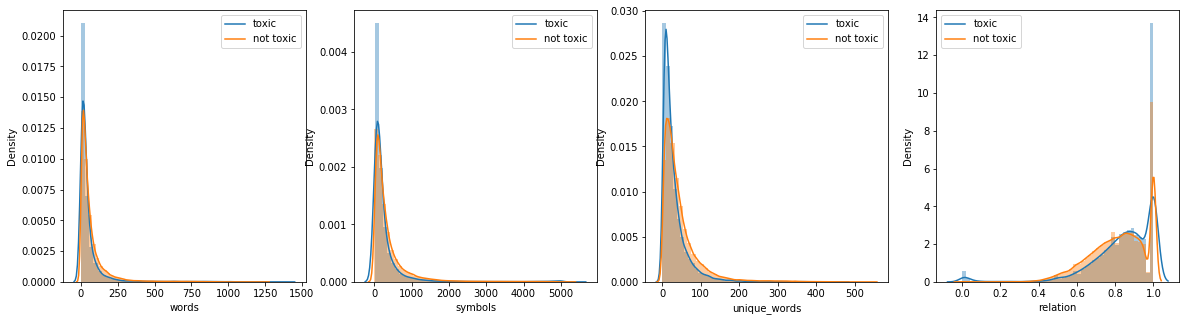

In [19]:
toxic = comments[comments.toxic == 1]
not_toxic = comments[comments.toxic == 0]

_, axes = plt.subplots(1, 4 , figsize=(20,5))
for i, column in enumerate(['words', 'symbols', 'unique_words', 'relation']):
  sns.distplot(toxic[column], ax=axes[i]);
  sns.distplot(not_toxic[column], ax=axes[i]);
  axes[i].legend(['toxic','not toxic'])

In [20]:
comments[comments.toxic == 1][['words', 'symbols', 'unique_words', 'relation']].describe()

,words,symbols,unique_words,relation
count,16225.000000,16225.000000,16225.000000,16225.000000
mean,54.102866,286.137565,31.318213,0.841095
std,109.991565,588.226221,36.232816,0.176216
min,2.000000,7.000000,1.000000,0.000800
25%,11.000000,56.000000,10.000000,0.768116
50%,23.000000,120.000000,20.000000,0.875000
75%,51.000000,268.000000,39.000000,1.000000
max,1403.000000,5417.000000,469.000000,1.000000


In [21]:
comments[comments.toxic == 0][['words', 'symbols', 'unique_words', 'relation']].describe()

,words,symbols,unique_words,relation
count,143346.000000,143346.000000,143346.000000,143339.000000
mean,69.679893,384.419907,46.240865,0.817241
std,99.704957,560.532295,48.601422,0.145436
min,0.000000,0.000000,0.000000,0.000800
25%,18.000000,94.000000,16.000000,0.720000
50%,38.000000,204.000000,32.000000,0.833333
75%,79.000000,432.000000,58.000000,0.935484
max,1250.000000,5238.000000,544.000000,1.000000


В токсичных комментариях среднее значение количества слов - выше. В распределении количества символов у токсичных и нетоксичных комментариев дисперсия примерно одинаковая, но среднее значение у токсичных комментариев выше (возможно, используется много восклицательных знаков).

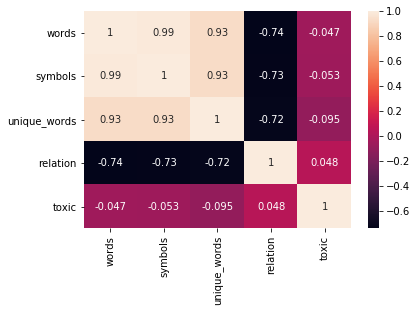

In [22]:
sns.heatmap(comments[['words', 'symbols', 'unique_words', 'relation', 'toxic']].corr(), annot=True);

Из таблицы корреляции следует, что связь между токсичностью и количеством слов/символов очень слабая, но корреляция между количеством уникальных слов и токсичностью - сильнее.

In [23]:
# посмотрим на баланс классов
comments.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

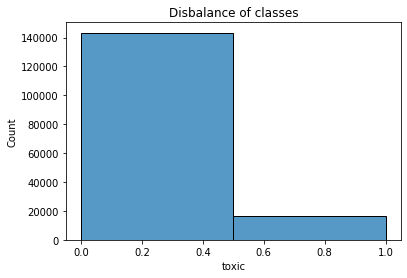

In [24]:
sns.histplot(comments.toxic, bins=2);
plt.title('Disbalance of classes');

Видим значительный дисбаланс классов. Устраним его, увеличив количество токсичных комментариев.

In [25]:
# разделим выборку на тестовую и обучающую
train, test = train_test_split(comments, random_state=42, test_size=0.3)
print(train.shape, test.shape)

(111699, 7) (47872, 7)


Сбалансируем обучающую выборку.

Train sample: (111699, 7) -> (191205, 7)


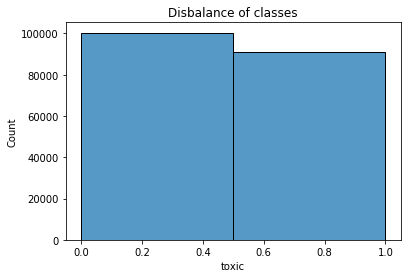

In [26]:
# получим индексы
toxic_index = train[train.toxic == 1].index
not_toxic_index = train[train.toxic == 0].index

train_balanced = train.loc[not_toxic_index]
# во сколько раз увеличить
N = int(len(not_toxic_index)/len(toxic_index))

toxic = pd.concat([train.loc[toxic_index]]*N)
train_balanced = pd.concat([train_balanced, toxic]).sample(frac=1).reset_index(drop=True)

print('Train sample:', train.shape, '->', train_balanced.shape)

# получили сбалансированную выборку
sns.histplot(train_balanced.toxic, bins=2);
plt.title('Disbalance of classes');

In [27]:
# разделим признаки и целевую переменную

X_train = train['lemm_text']
y_train_tf = train['toxic']
X_test = test['lemm_text']
y_test_tf = test['toxic']

print(X_train.shape, y_train_tf.shape, X_test.shape, y_test_tf.shape)

(111699,) (111699,) (47872,) (47872,)


In [28]:
# обучим TF IDF на обучающей выборке
stop_words = set(stopwords.words('english'))
count_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
tfidf = count_tfidf.fit(X_train.values)

In [29]:
# преобразуем обучающую и тестовую выборки в TF-IDF
X_train_tf = tfidf.transform(X_train.values)
X_test_tf = tfidf.transform(X_test.values)
print(X_train_tf.shape, X_test_tf.shape)

(111699, 145275) (47872, 145275)


## 2. Обучение

Обучим модели на основе алгоритмов:
* логистическая регрессия *LogisticRegression()* с использованием *эмбеддингов* в качестве признаков
* логистическая регрессия *LogisticRegression()* с использованием признаков в виде *TF-IDF*
* стохастический градиентный спуск *SGDClassifier() (признаки TF-IDF)*
* случайный лес *RandomForestClassifier() (признаки TF-IDF)*

In [30]:
scores_data = pd.DataFrame()

### LogisticRegression

In [31]:
%%time

log_tf = LogisticRegression(class_weight='balanced', penalty='l2', random_state=42, n_jobs=-1)
log_tf.fit(X_train_tf, y_train_tf)

CPU times: user 84.4 ms, sys: 161 ms, total: 245 ms
Wall time: 8.52 s


LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [32]:
cross_valid(log_tf, X_train_tf, y_train_tf)

Train (validation) F1: [0.74451675 0.7434555  0.74616858]


In [33]:
log_tf_score = score_stat(log_tf, X_train_tf, y_train_tf, X_test_tf, y_test_tf, model_name='LogisticRegression_TFIDF')
log_tf_score

,model,metric,train,test
0,LogisticRegression_TFIDF,precision,0.744697,0.676234
1,LogisticRegression_TFIDF,recall,0.970505,0.847134
2,LogisticRegression_TFIDF,f1,0.842737,0.752098
3,LogisticRegression_TFIDF,roc_auc,0.966422,0.900616


In [34]:
scores_data = pd.concat([scores_data,log_tf_score])

### SGDClassifier

In [35]:
%%time

clf = SGDClassifier(max_iter=80000, tol=1e-4, penalty='elasticnet', alpha=0.01, verbose=False, 
                    l1_ratio=0.19, loss='hinge', random_state=42, learning_rate='optimal')

sdg = make_pipeline(StandardScaler(with_mean=False), clf)
sdg.fit(X_train_tf, y_train_tf)

CPU times: user 8.17 s, sys: 103 ms, total: 8.27 s
Wall time: 8.19 s


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, l1_ratio=0.19, max_iter=80000,
                               penalty='elasticnet', random_state=42,
                               tol=0.0001, verbose=False))])

In [36]:
cross_valid(sdg, X_train_tf, y_train_tf)

Train (validation) F1: [0.73630033 0.74556575 0.74141104]


In [37]:
sdg_score = score_stat(sdg, X_train_tf, y_train_tf, X_test_tf, y_test_tf, model_name='SGDClassifier_TFIDF')
sdg_score

,model,metric,train,test
0,SGDClassifier_TFIDF,precision,0.937167,0.901588
1,SGDClassifier_TFIDF,recall,0.697306,0.653174
2,SGDClassifier_TFIDF,f1,0.799637,0.757536
3,SGDClassifier_TFIDF,roc_auc,0.846007,0.822553


In [38]:
scores_data = pd.concat([scores_data, sdg_score])

### RandomForestClassifier

In [39]:
%%time

rf = RandomForestClassifier(n_estimators=1000, max_depth=50, oob_score=True, 
                            random_state=42, class_weight='balanced', n_jobs=-1, 
                            criterion='gini', min_samples_leaf=5)
rf.fit(X_train_tf, y_train_tf)

CPU times: user 7min 46s, sys: 1.31 s, total: 7min 47s
Wall time: 2min 22s


RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=5, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=42)

In [40]:
cross_valid(rf, X_train_tf, y_train_tf)

Train (validation) F1: [0.46148202 0.46004807 0.46371915]


In [41]:
rf_score = score_stat(rf, X_train_tf, y_train_tf, X_test_tf, y_test_tf, 
                      model_name='RandomForestClassifier_TFIDF')
rf_score

,model,metric,train,test
0,RandomForestClassifier_TFIDF,precision,0.337829,0.314969
1,RandomForestClassifier_TFIDF,recall,0.906410,0.838710
2,RandomForestClassifier_TFIDF,f1,0.492207,0.457957
3,RandomForestClassifier_TFIDF,roc_auc,0.852653,0.816134


In [42]:
scores_data = pd.concat([scores_data, rf_score])

## 3. Выводы

In [43]:
# посмотрим на собранную статистику
scores_data

,model,metric,train,test
0,LogisticRegression_TFIDF,precision,0.744697,0.676234
1,LogisticRegression_TFIDF,recall,0.970505,0.847134
2,LogisticRegression_TFIDF,f1,0.842737,0.752098
3,LogisticRegression_TFIDF,roc_auc,0.966422,0.900616
0,SGDClassifier_TFIDF,precision,0.937167,0.901588
1,SGDClassifier_TFIDF,recall,0.697306,0.653174
2,SGDClassifier_TFIDF,f1,0.799637,0.757536
3,SGDClassifier_TFIDF,roc_auc,0.846007,0.822553
0,RandomForestClassifier_TFIDF,precision,0.337829,0.314969
1,RandomForestClassifier_TFIDF,recall,0.906410,0.838710


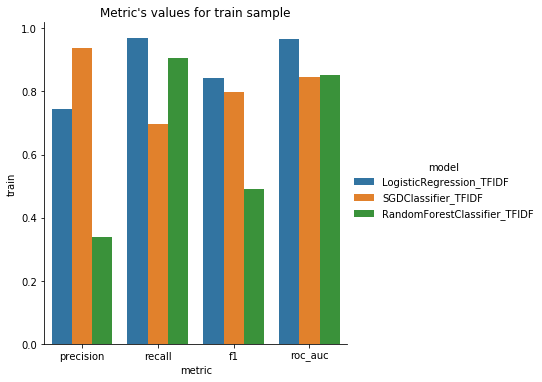

In [44]:
sns.catplot(x="metric", y="train", hue='model', kind="bar", data=scores_data);
plt.title("Metric's values for train sample");

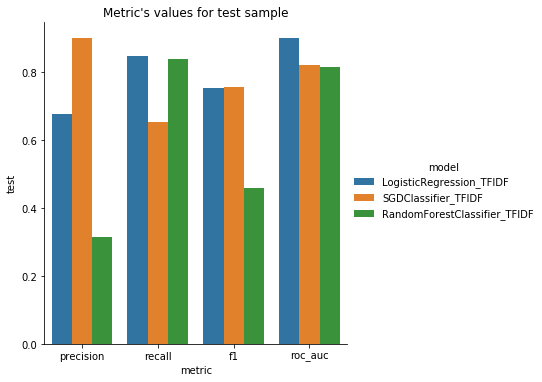

In [45]:
sns.catplot(x="metric", y="test", hue='model', kind="bar", data=scores_data);
plt.title("Metric's values for test sample");

## Вывод

В результате исследования задачи выявлено, что сильное влияние на качество моделей оказывает дисбаланс классов. В реузльтате обучения и тестирования собрана статистика значений разных метрик:
* быстрее всего обучается алгоритм *LogisticRegression* на эмбеддингах, однако получение таких признаков занимает большое количество времени;
* среди моделей, обученных на признаках TF-IDF, самые быстрые *LogisticRegression* и *SGDClassifier*;
* долго обучается алгоритм RandomForestClassifier, качество ниже требуемого.

Наиболее подходящим алгоритмом по качеству и времени обучения выбрана логистическая регрессия LogisticRegression() - F1=0.75.